In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import random
import pandas as pd
import matplotlib 

from scipy.stats import invwishart

matplotlib.rcParams['figure.figsize'] = (16, 16)

##### Generate data with normal distribution

In [2]:
params = [
            {"pi": 0.2, "mu": (2, 3), "covariance": [[2, 1], [1, 4]]},
            {"pi": 0.5, "mu": (4, 4), "covariance": [[1, 0], [0, 1]]},
            {"pi": 0.3, "mu": (6, 3), "covariance": [[3, 2], [2, 6]]},
        ]

In [3]:
total_toss = 900
num_cluster = len(params)

In [4]:
def gen_data(num_cluster, total_toss):
    Z = [np.random.choice(num_cluster, 1, p=[params[i]['pi'] for i in range(num_cluster)])[0] for n_toss in range(total_toss)]
    data_dist = Counter(Z)
    data = {}
    for i in range(0, num_cluster):
        if data_dist[i] != 0: 
            data[i] = np.squeeze(np.random.multivariate_normal(params[i]["mu"], params[i]["covariance"], (1, data_dist[i])))
    return Z, data

In [5]:
actual_Z, data = gen_data(num_cluster, total_toss)

In [6]:
d = {k:v.tolist() for k, v in data.items()}

In [7]:
d_list = []
for k, v in d.items():
    for i in v:
        d_list.append([i[0], i[1], k])
dframe = pd.DataFrame(d_list, columns = ["X", "Y", "label"])

### Visualisation of actual labels 

<AxesSubplot:xlabel='X', ylabel='Y'>

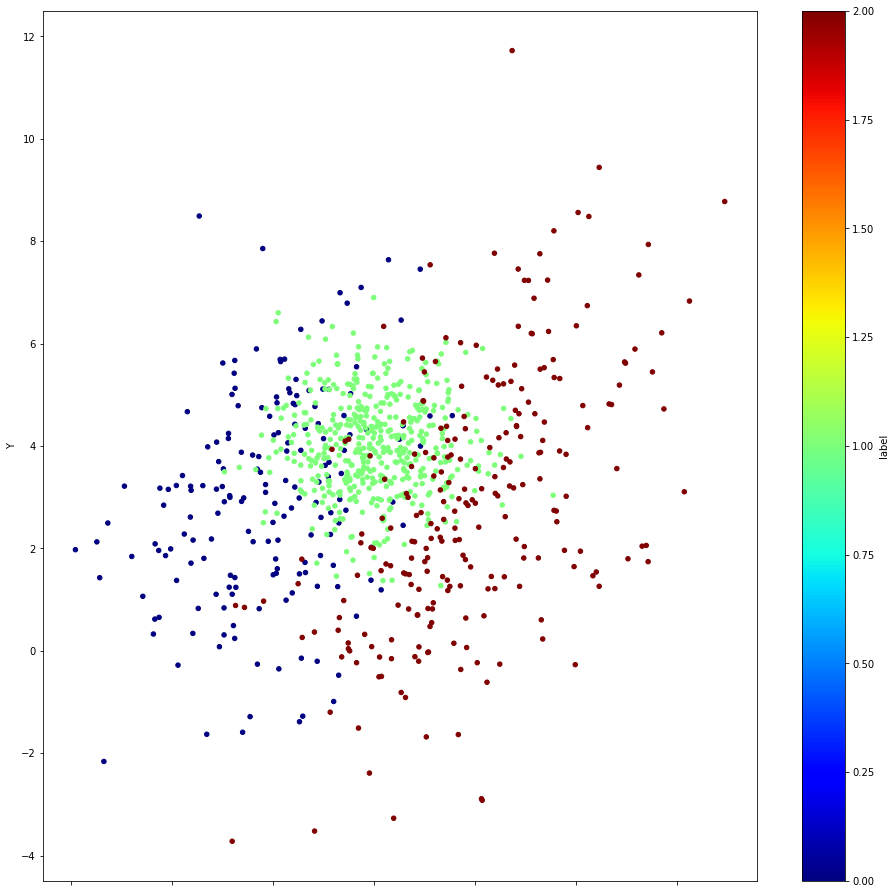

In [8]:
dframe.plot.scatter('X', 'Y', c='label', colormap='jet')

##### Generate covariance matrix 

In [9]:
def gen_cov_matrix(data):
    cov_matrix = {}
    # Covariance
    def cov(x, y):
        xbar, ybar = x.mean(), y.mean()
        return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

    # Covariance matrix
    def cov_mat(X):
        return np.array([[cov(X[0], X[0]), cov(X[0], X[1])], \
                         [cov(X[1], X[0]), cov(X[1], X[1])]])

    
    for i in range(len(data)):
        # Calculate covariance matrix 
        cov_matrix[i] = cov_mat(data[i].T) # (or with np.cov(X.T))
        
    return cov_matrix

##### Generate labels 

In [10]:
Z = [np.random.choice(num_cluster, 1, p=[1/num_cluster for i in range(num_cluster)])[0] for n_toss in range(total_toss)]

In [11]:
data_list = []
for key, value in data.items():
    data_list.append(value.tolist())

In [12]:
data_list = list(itertools.chain(*data_list))

### Gaussian Prior

In [13]:
def gaussian_pdf(x_vector, mu_vector, covariance):
    # use case 
    # gaussian_pdf(np.array([3,2]), np.array([4,5]), np.array([[2,3], [3,2]]))
    D = len(x_vector)
    inv_covariance = np.linalg.inv(covariance)
    exp_term = np.exp(-0.5*np.dot(np.dot(np.transpose(x_vector-mu_vector),inv_covariance),(x_vector-mu_vector)))
    return (1/(2*np.pi)**D/2) * (1/np.abs(np.linalg.det(covariance))**0.5) * exp_term

In [14]:
# generate clusters by removing a data 
# gibbs sampling
def generate_cluster(X, data_i, Z, n_z):
    clusters = {}
    cluster_x = {}
    cluster_y = {}

    for k in range(0, n_z):
        clusters[k] = []
        cluster_x[k] = []
        cluster_y[k] = []
    
    for (x, z) in zip(X, Z):
        if (x == data_i).any():
            continue
        cluster_x[z].append(x[0])
        cluster_y[z].append(x[1])
    
    for k in range(len(cluster_x)):
        clusters[k] = np.vstack([cluster_x[k], cluster_y[k]]).T
        
    return clusters

In [16]:
def sample_covariance(data, mu, lmbda=1, nu=4, psi=np.eye(2)):
    n = len(data[:,0])
    mean_data = np.mean(data, axis=0)
    sum_squares = np.sum([np.array(np.matrix(x-mean_data).T * np.matrix(x-mean_data)) for x in data], axis = 0)
    mu_n = (lmbda * mu + n * mean_data) / (lmbda + n)
    lmbda_n = lmbda + n
    nu_n = nu + n
    psi_n = psi + sum_squares + ((lmbda * n) / float(lmbda + n)) * np.array(np.matrix(mean_data - mu).T * np.matrix(mean_data - mu))
    return invwishart.rvs(nu_n, psi_n, size=1)

##### Known parameters 

In [18]:
def calculate_prob(X, x, Z, count, A, N):
    final_prob = []
    norm_final_prob = []
    
    clusters = generate_cluster(X, x, Z, num_cluster)

    
    for k in range(num_cluster):
        covariance = sample_covariance(clusters[k], params[k]['mu'])
        k_prob = gaussian_pdf(x, params[k]['mu'], covariance)
        pr = ((count[k] + A/num_cluster)/(N + A - 1)) * k_prob

        final_prob.append(pr)
    
    sum_prob = sum(final_prob)
    for i in range(0, num_cluster):
        norm_final_prob.append(final_prob[i]/sum_prob)
    return norm_final_prob, final_prob

In [19]:
new_Z = [np.random.choice(num_cluster, 1, p=[1/num_cluster for i in range(num_cluster)])[0] for n_toss in range(3*total_toss)] 

data_numpy = [np.array(d) for d in data_list]

count = Counter(new_Z)
A = 0.1
N = len(data_numpy)

In [20]:
total_performance = []
total_iter = 30
for v in range(total_iter):
    performance = [] 

    for i, (x, z) in enumerate(zip(data_numpy, new_Z)):
        norm_final_prob, final_prob = calculate_prob(data_numpy, x, new_Z, count, A, N)
        new_Z[i] = (np.random.choice(num_cluster, 1, p=norm_final_prob)[0])
    
    
        performance.append(np.log(np.sum(final_prob)))
    total_performance.append(np.sum(performance))

### Compute maximum likelihood estimate 

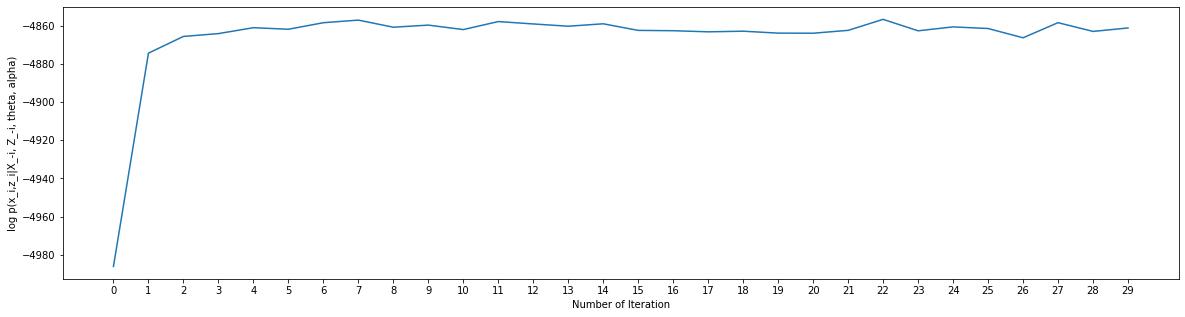

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(total_performance)
plt.xlabel("Number of Iteration")
plt.ylabel("log p(x_i,z_i|X_-i, Z_-i, theta, alpha)")
plt.xticks([i for i in range(total_iter)])

plt.show()

##### Create DataFrame

In [22]:
df_list = []
for d, new_z, a_z in zip(data_list, new_Z, actual_Z):
    if a_z != new_z:
        val = num_cluster
    else:
        val = a_z
    df_list.append([d[0], d[1], new_z, a_z, val])

In [23]:
frame = pd.DataFrame(df_list, columns = ["X", "Y", "model_label", "actual_label", "label==random_label"])

<AxesSubplot:xlabel='X', ylabel='Y'>

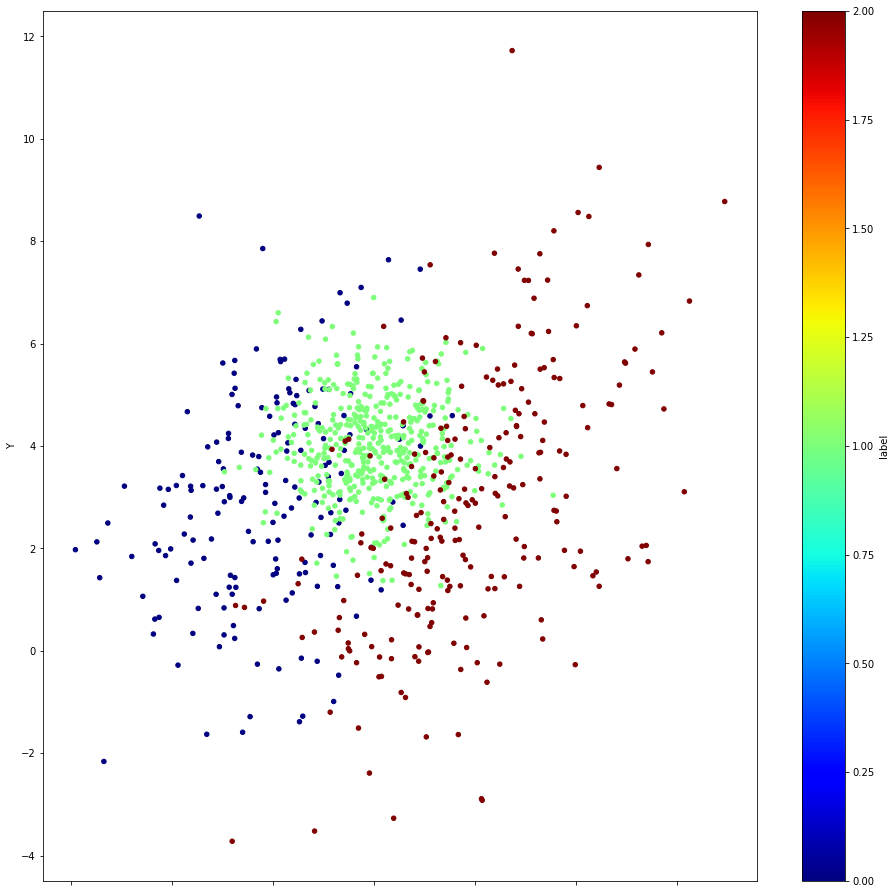

In [24]:
dframe.plot.scatter('X', 'Y', c='label', colormap='jet')

<AxesSubplot:xlabel='X', ylabel='Y'>

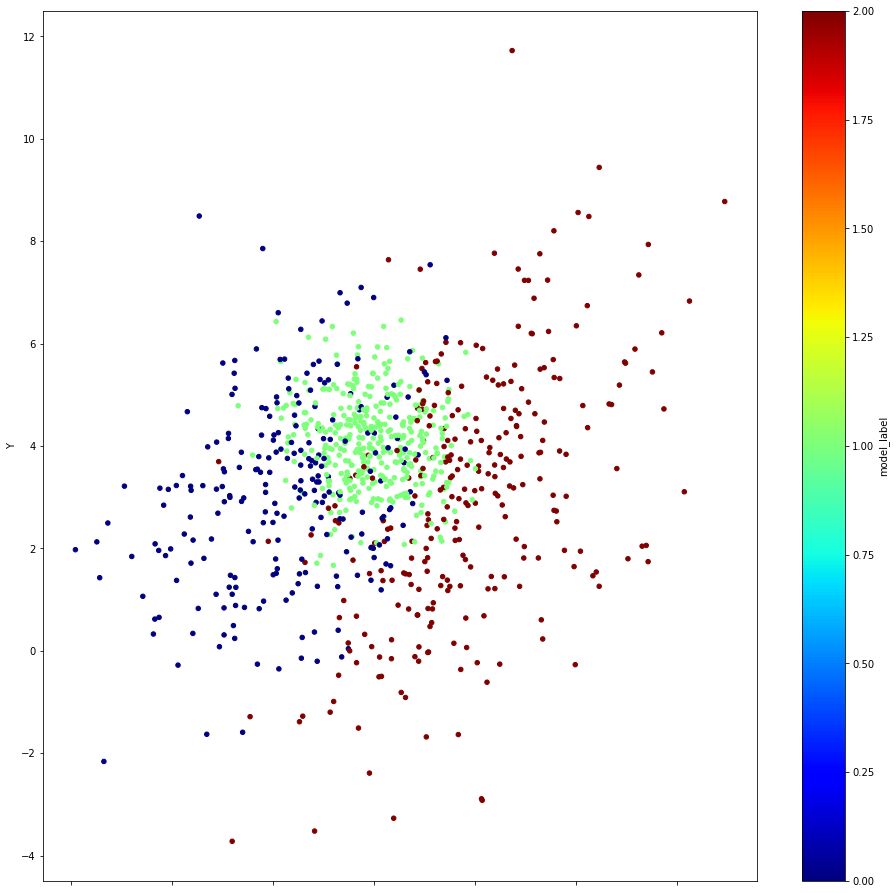

In [25]:
frame.plot.scatter('X', 'Y', c='model_label', colormap='jet')

### Calculate mixture proportions 

In [26]:
model_params = []
for i, df in frame.groupby('model_label'):
    d = {}
    d['pi'] = len(df)/total_toss
    d['mu'] = (np.round(np.mean(df[["X"]].to_numpy().T),2), np.round(np.mean(frame[["Y"]].to_numpy().T),2))
    d['covariance'] = np.round(np.cov(df[["X", "Y"]].to_numpy().T), 2).tolist()
    model_params.append(d)

In [31]:
model_params

[{'pi': 0.26, 'mu': (2.25, 3.5), 'covariance': [[2.17, 0.84], [0.84, 3.26]]},
 {'pi': 0.4255555555555556,
  'mu': (3.98, 3.5),
  'covariance': [[0.73, -0.08], [-0.08, 0.77]]},
 {'pi': 0.31444444444444447,
  'mu': (5.87, 3.5),
  'covariance': [[2.79, 1.98], [1.98, 5.97]]}]

In [32]:
params

[{'pi': 0.2, 'mu': (2, 3), 'covariance': [[2, 1], [1, 4]]},
 {'pi': 0.5, 'mu': (4, 4), 'covariance': [[1, 0], [0, 1]]},
 {'pi': 0.3, 'mu': (6, 3), 'covariance': [[3, 2], [2, 6]]}]